One of the most common probability distributions is the normal (or Gaussian) distribution.  Many natural phenomena can be modelled using a normal distribution.  It's also of great importance due to its relation to the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem).

In this post, we'll be reviewing the normal distribution and looking at how to draw samples from it using two methods.  One naive method using the central limit theorem, and another using the [Box-Muller transform](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform).  As usual, some brief coverage of proofs and code will be included to help drive intuition.


## Background

### Normal Distribution

Let's first start off covering some basics.  A normal distribution (also known as a Gaussian distribution) \\(N \sim (\mu, \sigma)\\) has probability density function (PMF) and cumulative density function (CDF) shown here [<sup>[1]</sup>](#fn-1):

$$ f_N(x) = \frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{(x-\mu)^2}{2\sigma}} \tag{1}$$
$$ F_N(x) = \int_{-\infty}^{x}f_N(t) dt  \tag{2}$$

The CDF doesn't have a nice closed form, so we'll just represent it here using the definition of CDF in terms of its PDF.  We can graph the PDF and CDF (images from [Wikipedia](https://en.wikipedia.org/wiki/Normal_distribution)):

![PDF of Normal Distribution](/images/normal_pdf_cdf.png)

The normal distribution is sometimes colloquially known as the "bell curve" because of a it's symmetric hump.  A very common thing with a probability distribution is to *sample* from it.  In other words, we want to randomly generate numbers (i.e. \\(x\\) values) such that the values of \\(x\\) are in proportion to the PDF.  So for the standard normal distribution, \\(N \sim (0, 1) \\) (the red curve in the picture above), most of the values would fall close to somewhere around \\(x=0\\).  In fact, 68% will fall within \\([-1, 1]\\), 95% will fall within \\([-2,2]\\) and 99.7% will fall within \\([-3,3]\\).  This corresponds to \\(\sigma, 2\sigma, 3\sigma\\) from the mean, see this [article](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule) for more details.

### Central Limit Theorem

The central limit theorem (CLT) is quite a surprising result relating the sample average of \\(n\\) [indepededent and identially distributed](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) (i.i.d.) random variables and a normal distribution.  To state more precisely: 

> Let \\({X_1, X_2, \ldots, X_n}\\) be \\(n\\) i.i.d. random variables with \\(E(X_i)=\mu\\) 
> and \\(Var(X_i)=\sigma^2\\) and  let \\(S_n = \frac{X_1 + X_2 + \ldots + X_n}{n}\\) be the sample 
> average. Then \\(S_n\\) approximates a normal distribution with mean of \\(\mu\\) and 
> variance of \\(\frac{\sigma^2}{n}\\) for large \\(n\\) (i.e. \\(S_n \approx N(\mu, \frac{\sigma^2}{n})\\))

The surprising result is that \\(X_n\\) can be *any* shape of distribution.  It isn't restricted to just normal distributions.  We can also define the standard normal distribution in terms of \\(S_n\\) by shifting and scaling it:

$$ N(0,1) \approx \frac{S_n - \mu}{\frac{\sigma}{\sqrt{n}}} = \frac{\sqrt{n}(S_n - \mu)}{\sigma} \tag{3} $$

### Comparing Distributions

Since our goal is to implement sampling from a normal distribution, it would be nice to know if we actually did it correctly!  One common way to test if two arbitrary distributions are the same is to use the [Kolmogorov–Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test).  In the basic form, we can compare a sample of points with a reference distribution to find their similarity.  

The basic idea of the test is to sort the points in the sample and the compute the [empirical CDF](https://en.wikipedia.org/wiki/Empirical_distribution_function).  
Then compare the absolute difference between any point in the ECDF and the theoretical reference distribution.  If the two are the same, this difference should be very small. If it's large then we can be confident that the distribution is different.  Further, this difference follows a certain distribution, which allows us to test our null hypothesis of whether our samples were drawn from the reference distribution.  
The following figure (from [Wikipedia](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#Kolmogorov_distribution)) shows this more clearly:

![Kolmogorov–Smirnov test](/images/ks_test.png)

Fortunately, we don't have to implement this ourselves.  A package is available in [scipy.stats](http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html).  Let's play around with it a bit to see how it works.


In [54]:
from scipy import stats
import numpy as np

np.random.seed(123) 

# number of samples
N=100000

# Run Kolmogorov-Smirnov test Uniform(0,1) vs. reference N(0, 1)
samples = stats.uniform.rvs(loc=0, scale=1, size=N)
test_stat, pvalue = stats.kstest(samples, 'norm', args=(0, 1), N=N)
print("U(0,1) vs. N(0, 1): KS=%.4f with p-value = %.4f." % (test_stat, pvalue))

# Run Kolmogorov-Smirnov test N(0, 2) vs. reference N(0, 1)
samples = stats.norm.rvs(loc=0, scale=2, size=N) 
test_stat, pvalue = stats.kstest(samples, 'norm', args=(0, 1), N=N)
print("N(0,2) vs. N(0, 1): KS=%.4f with p-value = %.4f." % (test_stat, pvalue))

# Run Kolmogorov-Smirnov test N(0, 1) vs. reference N(0, 1)
samples = stats.norm.rvs(loc=0, scale=1, size=N) 
test_stat, pvalue = stats.kstest(samples, 'norm', args=(0, 1), N=N)
print("N(0,1) vs. N(0, 1): KS=%.4f with p-value = %.4f." % (test_stat, pvalue))

U(0,1) vs. N(0, 1): KS=0.5000 with p-value = 0.0000.
N(0,2) vs. N(0, 1): KS=0.1615 with p-value = 0.0000.
N(0,1) vs. N(0, 1): KS=0.0022 with p-value = 0.7115.


Using \\(N(0,1)\\) as our reference distribution, the KS test has a large value and a neglible p-value when comparing to a uniform distribution \\(U(0,1)\\) (\\(KS=(0.5\\)) as well a normal distribution with a wider base \\(N(0, 2)\\) (\\(KS=0.1615\\)).  However, when we compare samples from the identical distribution \\(N(0,1)\\), we get a relatively small value (\\(KS=0.0022\\)) for the test statistic and a large p-value, indicating we have no evidence to reject the null hypothesis (that our two distributions are the same).


## Naive Sampling using the Central Limit Theorem

Now let's try to use the Central Limit Theorem to sample from \\(N(0,1)\\).  First let's define our i.i.d. variable \\(X_n\\) to have [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) with \\(p=0.5\\), which we can intuitively think of tossing an unbiased coin:

$$ P(X_n=k) = \begin{cases} p=0.5 & \text{if }k=1, \\[6pt] 1-p = 0.5 & \text {if }k=0.\end{cases}</math> \tag{4} $$

Recall, the Bernoulli distribution is closely relates to the [Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) denoted by \\(B(n, p)\\) by \\Bernoulli(p) = B(n=1, p\\) .  The Binomial distribution can intuitively be thought of as counting the number of heads in \\(n\\) tosses of a coin (i.e. Bernoulli trials).  If \\(n=1\\), it reduces to a single Bernoulli distribution (or coin toss).

Let's now define our sample average for \\(n\\) tosses of our unbiased coin:

$$ S_n = \frac{X_1 + X_2 + \ldots + X_n}{n} = \frac{B(n, p=0.5)}{n} $$

We can see that this distribution has \\(mu=\frac{n}{2}\\) (we expect half our tosses to be heads), and \\(\sigma^2=\frac{p(1-p)}{n}=\frac{0.25}{n}\\) (Bernoulli RVs have \\(\sigma^2 = p(1-p)\\)).

Shifting and scaling this to get our standard normal distribution using Equation 3, we get:

\begin{align} 
N(0,1) &\approx \frac{\sqrt{n}(S_n - \mu)}{\sigma} \\
       &= \frac{\sqrt{n}(\frac{X_1 + X_2 + \ldots + X_n}{n} - 0.5)}{\sqrt{0.25}} \\
       &= 2\sqrt{n}(\frac{X_1 + X_2 + \ldots + X_n}{n} - 0.5) \tag{5}
\end{align} 

Theoretically, this should give us an equation to roughly simulate a standard normal distribution.  Let's try it!

sample_N(0,1) vs. N(0, 1): KS=0.0174 with p-value = 0.0969.


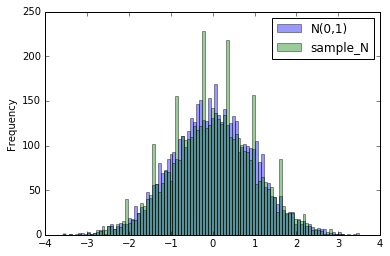

In [240]:
%matplotlib inline
import random
import pandas as pd
import math

N=5000
random.seed(123)

def bernoulli():
    return random.randint(0,1)

# Our sample function of N(0,1) using Equation 5
def sampleN_v1(N=1000):
    return 2.0 * math.sqrt(N) * (sum(bernoulli() for x in range(N)) / N - 0.5)

# Use KS to test again
samples = [sampleN_v1() for x in range(N)]
test_stat, pvalue = stats.kstest(samples, 'norm', args=(0, 1), N=N)
print("sample_N(0,1) vs. N(0, 1): KS=%.4f with p-value = %.4f." % (test_stat, pvalue))

# Let's plot our samples against our reference distribution
reference = [stats.norm.rvs() for x in range(N)]
pd.DataFrame({'sample_N': samples, 'N(0,1)': reference}).plot(kind='hist', bins=100, alpha=0.4)

## References and Further Reading

* Wikipedia: [Normal Distribution](https://en.wikipedia.org/wiki/Normal_distribution), [Box-Muller Transform](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform), [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem)

## Notes

List of Notes: [^1] 

[^1]: We'll use the convention of \\(f_X(x)\\) and \\(F_X(x)\\) to denote the PDF and CDF of random variable X, respectively.

